In [3]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

from TextCleaner import text_cleaner, get_vocabulary, create_embedding_vector
from Model import Encoder, Decoder, Summarizer

In [4]:
torch.manual_seed(0)
np.random.seed(0)

In [5]:
DATA_PATH = './AmazonReviews.csv'
GLOVE_PATH = './glove.6B.50d.txt'

data = pd.read_csv(DATA_PATH)
data.dropna(axis = 0, subset = 'Summary', inplace = True)

embedding_file = open(GLOVE_PATH, 'r', encoding = 'utf-8')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_data, val_data = train_test_split(data, test_size = 0.2, random_state = 42)

train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)

In [7]:
train_text = train_data['Text'].to_list()
train_summary = train_data['Summary'].to_list()
val_text = val_data['Text'].to_list()
val_summary = val_data['Summary'].to_list()

word_set = get_vocabulary(train_text, train_summary)

max_summary_len = 20
max_text_len = 500

embeddings, index2word, word2index = create_embedding_vector(embedding_file, word_set)
embeddings = torch.from_numpy(embeddings).to(device)

train_text_summary = []
val_text_summary = []

for i in range(0, len(train_text)):
    temp_clean_text = text_cleaner(train_text[i], False, max_text_len)
    temp_clean_summary = text_cleaner(train_summary[i], True, max_summary_len)
    train_text_summary.append((temp_clean_text, temp_clean_summary))

for i in range(0, len(val_text)):
    temp_clean_text = text_cleaner(val_text[i], False, max_text_len)
    temp_clean_summary = text_cleaner(val_summary[i], True, max_summary_len)
    val_text_summary.append((temp_clean_text, temp_clean_summary))

/kaggle/working/TextCleaner.py:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  ctext = BeautifulSoup(ctext, "lxml").text


In [8]:
embeddings.shape

torch.Size([22076, 50])

In [9]:
def get_word_indexes(word_bag):
    return list(int(word2index.get(t, word2index['<OOV>'])) for t in word_bag)


train_sorted = sorted(train_text_summary, key = lambda x: len(x[0]))
val_sorted = sorted(val_text_summary, key = lambda x: len(x[0]))


X_train = [torch.tensor(get_word_indexes(x[0])) for x in train_sorted]
y_train = [torch.tensor(get_word_indexes(x[1])) for x in train_sorted]

X_val = [torch.tensor(get_word_indexes(x[0])) for x in val_sorted]
y_val = [torch.tensor(get_word_indexes(x[1])) for x in val_sorted]

In [10]:
### Hyperparameters

batch_size = 32
hidden_dim = 64
embedding_dim = 50
vocab_size = embeddings.shape[0]

n_train = len(X_train)
n_val = len(X_val)

In [59]:
### Seq2Seq without Attention

encoder_model = Encoder(embedding_dim, hidden_dim, embeddings)
decoder_model = Decoder(embedding_dim, hidden_dim, vocab_size, embeddings)
model = Summarizer(encoder_model, decoder_model, word2index['<SOS>'], device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.NLLLoss()

In [63]:
n_epochs = 100
train_loss_values = []
train_bleu_values = []
validation_bleu_values = []

for epoch in range(1, n_epochs+1):

    total_train_loss = 0
    
    total_train_bleu = 0
    total_val_bleu = 0
    
    model.train()
    for i in range(0, len(X_train), batch_size):
        X = torch.nn.utils.rnn.pad_sequence(X_train[i:i+batch_size], batch_first = True, padding_value = 0).to(device)
        y = torch.nn.utils.rnn.pad_sequence(y_train[i:i+batch_size], batch_first = True, padding_value = 0).to(device)

        optimizer.zero_grad()
        outputs = model.forward(X, y)
        loss = criterion(outputs.view(-1, outputs.size(-1)), y.view(-1))
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        
        for i in range(0, len(X_train), batch_size):
            X = torch.nn.utils.rnn.pad_sequence(X_train[i:i+batch_size], batch_first = True, padding_value = word2index['<PAD>']).to(device)
            y = torch.nn.utils.rnn.pad_sequence(y_train[i:i+batch_size], batch_first = True, padding_value = word2index['<PAD>']).to(device)
            
            outputs = model.predict(X, y.shape[1])
            
            output_tokens = torch.argmax(outputs, dim = -1).cpu().numpy()
            actual_tokens = y.cpu().numpy()
            for i in range(0, actual_tokens.shape[0]):
                bleu_score = sentence_bleu(actual_tokens[i, :].reshape(1, -1), output_tokens[i, :].reshape(-1))
                total_train_bleu += bleu_score

        for i in range(0, len(X_val), batch_size):
            X = torch.nn.utils.rnn.pad_sequence(X_val[i:i+batch_size], batch_first = True, padding_value = word2index['<PAD>']).to(device)
            y = torch.nn.utils.rnn.pad_sequence(y_val[i:i+batch_size], batch_first = True, padding_value = word2index['<PAD>']).to(device)
            
            outputs = model.predict(X, y.shape[1])

            output_tokens = torch.argmax(outputs, dim = -1).cpu().numpy()
            actual_tokens = y.cpu().numpy()
            for i in range(0, actual_tokens.shape[0]):
                bleu_score = sentence_bleu(actual_tokens[i, :].reshape(1, -1), output_tokens[i, :].reshape(-1))
                total_val_bleu += bleu_score

    train_loss = total_train_loss / n_train
    train_bleu = total_train_bleu / n_train
    validation_bleu = total_val_bleu / n_val
    
    train_loss_values.append(train_loss)
    train_bleu_values.append(train_bleu)
    validation_bleu_values.append(validation_bleu)
    
    print('Epoch:', epoch)
    print('Train Loss:', train_loss)
    print('Train Bleu:', train_bleu)
    print('Validation Bleu:', validation_bleu)
    print('========================')

Epoch: 1
Train Loss: 0.09405980092166955
Train Bleu: 0.6096976775349451
Validation Bleu: 0.6142163715909241
Epoch: 2
Train Loss: 0.08055505105701528
Train Bleu: 0.6133632997485305
Validation Bleu: 0.6181905961874797
Epoch: 3
Train Loss: 0.07909761444855537
Train Bleu: 0.5409795966025224
Validation Bleu: 0.5458148341633522
Epoch: 4
Train Loss: 0.07796168779157342
Train Bleu: 0.48330628450202456
Validation Bleu: 0.48248699194466443
Epoch: 5
Train Loss: 0.0769095654022432
Train Bleu: 0.5298425298709003
Validation Bleu: 0.532535931521672
Epoch: 6
Train Loss: 0.07530090001661949
Train Bleu: 0.5476138394006607
Validation Bleu: 0.5532415337065236
Epoch: 7
Train Loss: 0.0738713691887769
Train Bleu: 0.5584008199545375
Validation Bleu: 0.5638028531497771
Epoch: 8
Train Loss: 0.07269483492060765
Train Bleu: 0.5695629283734002
Validation Bleu: 0.5744469899773624
Epoch: 9
Train Loss: 0.07144290982821541
Train Bleu: 0.5756379738324319
Validation Bleu: 0.5802630046900034
Epoch: 10
Train Loss: 0.07025

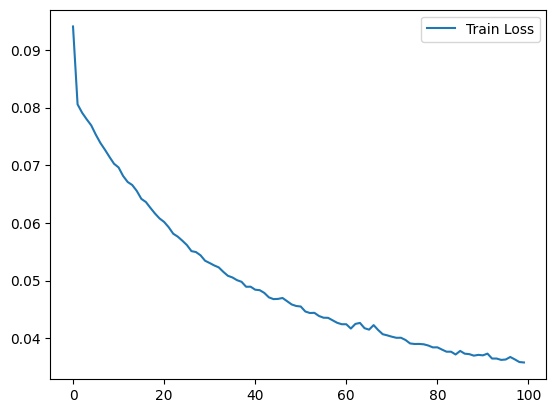

In [64]:
plt.plot(train_loss_values, label = 'Train Loss')
plt.legend()
plt.show()

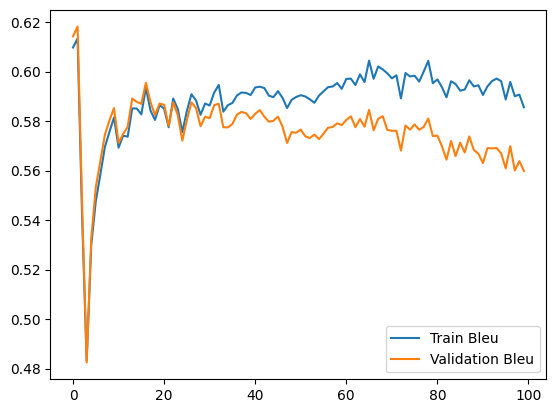

In [65]:
plt.plot(train_bleu_values, label = 'Train Bleu')
plt.plot(validation_bleu_values, label = 'Validation Bleu')
plt.legend()
plt.show()

In [68]:
test_indexes = [1032, 1921, 4923, 2375, 3394, 187, 329]

for idx in test_indexes:
    
    test_sentence = val_sorted[idx][0]
    test_summary = val_sorted[idx][1]

    
    test_tensor = torch.tensor(get_word_indexes(test_sentence), dtype = torch.int64, device = device).view(1, -1)

    
    model.eval()
    with torch.no_grad():
        test_output = torch.argmax(model.predict(test_tensor, max_summary_len).squeeze(), -1).cpu().numpy()

    
    print('Text:', ' '.join(test_sentence))
    print('Actual Summary:', ' '.join(test_summary))
    print('Predicted Summary:', ' '' '.join([index2word[x] for x in test_output]))
    print()

Text: roduct arrived timely six boxes i sampled this tea in a resturant and it was delicious cannot say the same for my purchase good tea but not as flavorful as bigelow
Actual Summary: time for tea <EOS>
Predicted Summary: oregon  vanilla  tea  <EOS>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>

Text: i have purchased green mountain pumpkin spice k cups for years it is my favorite coffee the packaging is new this year and the coffee has very little pumpkin and less spice i hate the flavor everyone who loved this coffee is complaining how disappointing
Actual Summary: pumpkin spice k cups <EOS>
Predicted Summary: breakfast  blend  at  a  <EOS>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>  <PAD>

Text: the title above refers not only to a semi obscure damon runyan based movie with bob hope but to these classic lemon drops with a truly international pedigree made in spa